In [3]:
#Importing necessary libraries 
import keras
import numpy as np
import pandas as pd
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
from keras import layers
from keras import optimizers
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

In [4]:
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights=None, include_top=False, input_shape=(64, 64, 3))

/home/sachin_sharma/.conda/envs/tf18/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [5]:
# Checking the trainable status of the individual layers
for layer in resnet_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa476055358> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fa47605f9b0> True
<keras.layers.convolutional.Conv2D object at 0x7fa47605f748> True
<keras.layers.normalization.BatchNormalization object at 0x7fa47605feb8> True
<keras.layers.core.Activation object at 0x7fa47605fcf8> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fa47473e668> True
<keras.layers.pooling.MaxPooling2D object at 0x7fa4757585f8> True
<keras.layers.convolutional.Conv2D object at 0x7fa475fc3400> True
<keras.layers.normalization.BatchNormalization object at 0x7fa474679898> True
<keras.layers.core.Activation object at 0x7fa474679a58> True
<keras.layers.convolutional.Conv2D object at 0x7fa47461e908> True
<keras.layers.normalization.BatchNormalization object at 0x7fa4745e1ac8> True
<keras.layers.core.Activation object at 0x7fa4745f86a0> True
<keras.layers.convolutional.Conv2D object at 0x7fa47472bfd0> True
<keras.layers.convolutional.Conv2D obj

In [6]:
# Adding classifier on top of Convolutional base
# create the model
model = models.Sequential()

# Add the resnet50 convolutional model
model.add(resnet_model)

# Adding new Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Showing summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 31,980,419
Trainable params: 31,927,299
Non-trainable params: 53,120
_________________________________________________________________


In [7]:
# Fitting the CNN to the images(Image Augmentation, Image Preprocessing)
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(  
        rescale=1./255,
        shear_range=0.2,             
        zoom_range=0.2,              
        horizontal_flip=True)


# Normalizing the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# path to dataset
os.chdir('/home/sachin_sharma/Desktop/exp_2_jpg')

# This will create 80:20 split of training and test set 
training_set = train_datagen.flow_from_directory(
        'TrainingSet',
         target_size=(64,64),
         batch_size=32,
         class_mode='categorical')

# This will create the Test set
test_set = test_datagen.flow_from_directory(
        'TestSet',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical', 
        shuffle=False)

Found 22528 images belonging to 3 classes.
Found 6460 images belonging to 3 classes.


In [8]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
          training_set, 
          steps_per_epoch=(training_set.samples/32),
          epochs=10,
          validation_data=test_set,
          validation_steps=(test_set.samples/32))

Epoch 1/10
704/704 [==============================] - 52s 73ms/step - loss: 0.9090 - acc: 0.8195 - val_loss: 0.4784 - val_acc: 0.8486
Epoch 2/10
704/704 [==============================] - 44s 62ms/step - loss: 0.5068 - acc: 0.8705 - val_loss: 0.3611 - val_acc: 0.8754
Epoch 3/10
704/704 [==============================] - 44s 62ms/step - loss: 0.4179 - acc: 0.8895 - val_loss: 0.3594 - val_acc: 0.8759
Epoch 4/10
704/704 [==============================] - 44s 63ms/step - loss: 0.3571 - acc: 0.8982 - val_loss: 0.3249 - val_acc: 0.8858
Epoch 5/10
704/704 [==============================] - 44s 63ms/step - loss: 0.2194 - acc: 0.9043 - val_loss: 0.4566 - val_acc: 0.8706
Epoch 6/10
704/704 [==============================] - 44s 62ms/step - loss: 0.1962 - acc: 0.9091 - val_loss: 0.1967 - val_acc: 0.9071
Epoch 7/10
704/704 [==============================] - 43s 61ms/step - loss: 0.1914 - acc: 0.9122 - val_loss: 0.1721 - val_acc: 0.9082
Epoch 8/10
704/704 [==============================] - 44s 62ms

In [9]:
# Visualizing the mapping between labels
training_set.class_indices


{'Else': 0, 'Industrial': 1, 'Residential': 2}

In [10]:
# Confusion Matrix 
Y_pred = model.predict_generator(test_set, test_set.samples//32 +1 )
y_pred = np.argmax(Y_pred, axis=1) # predictions
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
#print(cm)
# visualizing results in table
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

df = cm2df(cm, ["Else", "Industrial", "Residential"])
print(df)

Confusion Matrix
             Else  Industrial  Residential
Else         4775          10           15
Industrial     62         294          404
Residential    65          13          822


In [11]:
# Classification report
print('Classification Report')
target_names = ['Else','Industrial','Residential']
classificn_report = classification_report(test_set.classes, y_pred, target_names=target_names)
print(classificn_report)

Classification Report
              precision    recall  f1-score   support

        Else       0.97      0.99      0.98      4800
  Industrial       0.93      0.39      0.55       760
 Residential       0.66      0.91      0.77       900

   micro avg       0.91      0.91      0.91      6460
   macro avg       0.85      0.76      0.77      6460
weighted avg       0.93      0.91      0.90      6460



dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


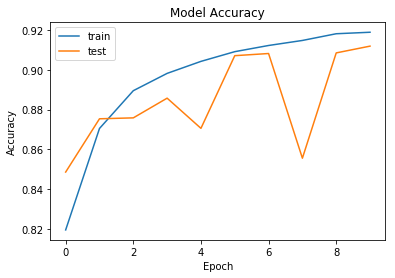

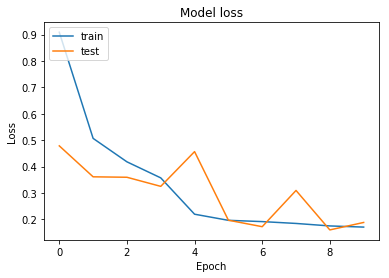

In [12]:
# Plotting the Loss and Classification Accuracy
model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
